<a href="https://colab.research.google.com/github/chaladi-tulasi/Nakshatra/blob/main/High_resolution_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os

In [ ]:
DATA_DIR = '/content/drive/MyDrive/AstroSR-main/dataset/HSC_train_HR'
SAVED_IMAGES = '/content/drive/MyDrive/srgan_results/'
os.makedirs(SAVED_IMAGES, exist_ok=True)

In [ ]:
import os
from PIL import Image

DATA_DIR = '/content/drive/MyDrive/AstroSR-main/dataset/HSC_train_HR'

image_files = [f for f in os.listdir(DATA_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Found {len(image_files)} images in DATA_DIR.")


Found 2000 images in DATA_DIR.


In [ ]:
LR_SIZE = (64, 64)
HR_SIZE = (256, 256)
BATCH_SIZE = 32
LEARNING_RATE = 0.0002

class SRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        lr_image = self.transform['lr'](image)
        hr_image = self.transform['hr'](image)
        return lr_image, hr_image

transform = {
    'lr': transforms.Compose([transforms.Resize(LR_SIZE), transforms.ToTensor()]),
    'hr': transforms.Compose([transforms.Resize(HR_SIZE), transforms.ToTensor()])
}

dataset = SRDataset(DATA_DIR, transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_residuals=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.conv3 = nn.Conv2d(64, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.conv1(x)
        residual = x
        x = self.res_blocks(x)
        x = self.conv2(x) + residual
        x = self.upscale(x)
        x = self.conv3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("Models saved successfully.")

Models saved successfully.


Epoch [0/5], Batch [0/63], D Loss: 0.6621, G Loss: 0.0664
Epoch [0/5], Batch [10/63], D Loss: 0.7507, G Loss: 0.0088
Epoch [0/5], Batch [20/63], D Loss: 0.5211, G Loss: 0.0111
Epoch [0/5], Batch [30/63], D Loss: 0.8118, G Loss: 0.0106
Epoch [0/5], Batch [40/63], D Loss: 0.6664, G Loss: 0.0077
Epoch [0/5], Batch [50/63], D Loss: 0.7977, G Loss: 0.0049
Epoch [0/5], Batch [60/63], D Loss: 0.6955, G Loss: 0.0040
Sample image saved at epoch 0


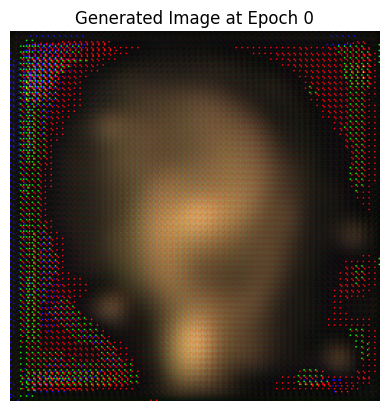

Epoch [1/5], Batch [0/63], D Loss: 0.6640, G Loss: 0.0044
Epoch [1/5], Batch [10/63], D Loss: 0.7233, G Loss: 0.0038
Epoch [1/5], Batch [20/63], D Loss: 0.6937, G Loss: 0.0030
Epoch [1/5], Batch [30/63], D Loss: 0.7034, G Loss: 0.0026
Epoch [1/5], Batch [40/63], D Loss: 0.7087, G Loss: 0.0026
Epoch [1/5], Batch [50/63], D Loss: 0.6932, G Loss: 0.0026
Epoch [1/5], Batch [60/63], D Loss: 0.6650, G Loss: 0.0025
Sample image saved at epoch 1


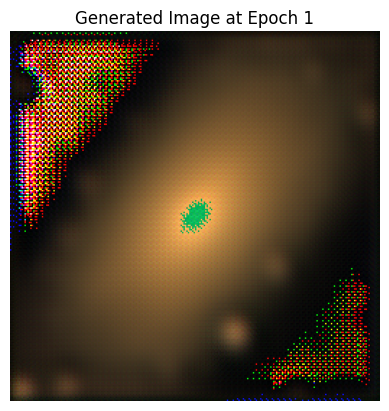

Epoch [2/5], Batch [0/63], D Loss: 0.6174, G Loss: 0.0027
Epoch [2/5], Batch [10/63], D Loss: 0.6395, G Loss: 0.0029
Epoch [2/5], Batch [20/63], D Loss: 0.6033, G Loss: 0.0034
Epoch [2/5], Batch [30/63], D Loss: 0.5683, G Loss: 0.0026
Epoch [2/5], Batch [40/63], D Loss: 0.6326, G Loss: 0.0027
Epoch [2/5], Batch [50/63], D Loss: 0.6620, G Loss: 0.0027
Epoch [2/5], Batch [60/63], D Loss: 0.6476, G Loss: 0.0028
Sample image saved at epoch 2


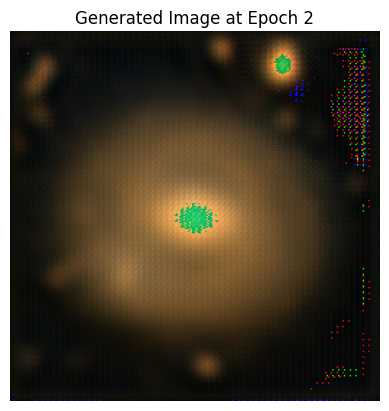

Epoch [3/5], Batch [0/63], D Loss: 0.5876, G Loss: 0.0030
Epoch [3/5], Batch [10/63], D Loss: 0.6525, G Loss: 0.0029
Epoch [3/5], Batch [20/63], D Loss: 0.6315, G Loss: 0.0035
Epoch [3/5], Batch [30/63], D Loss: 0.5957, G Loss: 0.0027
Epoch [3/5], Batch [40/63], D Loss: 0.5529, G Loss: 0.0037
Epoch [3/5], Batch [50/63], D Loss: 0.6078, G Loss: 0.0031
Epoch [3/5], Batch [60/63], D Loss: 0.6520, G Loss: 0.0031
Sample image saved at epoch 3


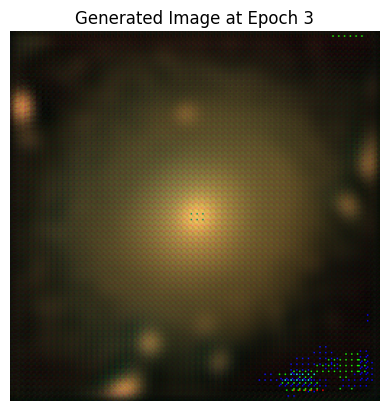

Epoch [4/5], Batch [0/63], D Loss: 0.7384, G Loss: 0.0036
Epoch [4/5], Batch [10/63], D Loss: 0.5511, G Loss: 0.0033
Epoch [4/5], Batch [20/63], D Loss: 0.7120, G Loss: 0.0028
Epoch [4/5], Batch [30/63], D Loss: 0.5924, G Loss: 0.0037
Epoch [4/5], Batch [40/63], D Loss: 0.6131, G Loss: 0.0029
Epoch [4/5], Batch [50/63], D Loss: 0.4460, G Loss: 0.0032
Epoch [4/5], Batch [60/63], D Loss: 0.6291, G Loss: 0.0044
Sample image saved at epoch 4


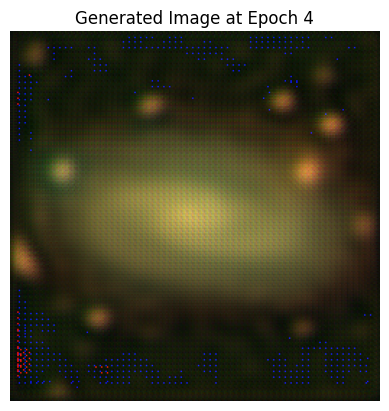

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import save_image
import torch

EPOCHS = 5
for epoch in range(EPOCHS):
    for i, (lr_imgs, hr_imgs) in enumerate(data_loader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        gen_hr_imgs = generator(lr_imgs)
        real_loss = bce_loss(discriminator(hr_imgs), torch.ones((hr_imgs.size(0), 1), device=device))
        fake_loss = bce_loss(discriminator(gen_hr_imgs.detach()), torch.zeros((lr_imgs.size(0), 1), device=device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = mse_loss(gen_hr_imgs, hr_imgs) + 1e-3 * bce_loss(discriminator(gen_hr_imgs), torch.ones((lr_imgs.size(0), 1), device=device))
        g_loss.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}], Batch [{i}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save and display sample images for evaluation every 1 epoch
    if epoch % 1 == 0:
        sample_image_path = f"{SAVED_IMAGES}/epoch_{epoch}.png"
        save_image(gen_hr_imgs, sample_image_path)
        print(f"Sample image saved at epoch {epoch}")
        gen_image_pil = to_pil_image(gen_hr_imgs[0].cpu().detach())
        plt.imshow(gen_image_pil)
        plt.axis('off')
        plt.title(f"Generated Image at Epoch {epoch}")
        plt.show()


In [ ]:
def load_model_and_infer(generator_model_path, lr_image_path):
    generator = Generator()
    generator.load_state_dict(torch.load(generator_model_path))
    generator.to(device)
    generator.eval()
    lr_image = Image.open(lr_image_path).convert("RGB")
    lr_image = transforms.ToTensor()(lr_image).unsqueeze(0).to(device)

    with torch.no_grad():
        gen_hr_image = generator(lr_image)

    save_image(gen_hr_image, "generated_hr_image.png")
    gen_image_pil = to_pil_image(gen_hr_image[0].cpu().detach())
    plt.imshow(gen_image_pil)
    plt.axis('off')
    plt.title("Generated High-Resolution Image")
    plt.show()

<ipython-input-10-31e5e3b282f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


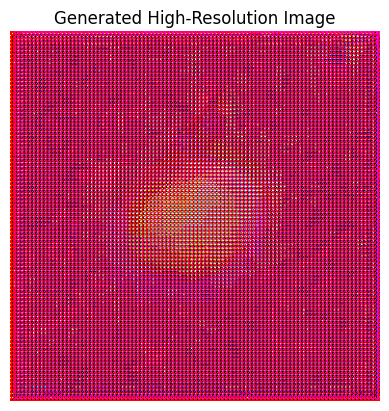

In [ ]:
load_model_and_infer("generator.pth", "/content/drive/MyDrive/AstroSR-main/dataset/SDSS_test_LR/X2/133.40822_4.224727.png")

<ipython-input-10-31e5e3b282f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


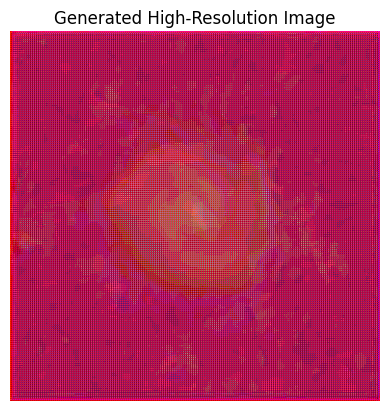

In [ ]:
load_model_and_infer("generator.pth", "/content/drive/MyDrive/AstroSR-main/dataset/SDSS_test_Bilinear/17.49903_-0.45353034.png")

<ipython-input-10-31e5e3b282f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


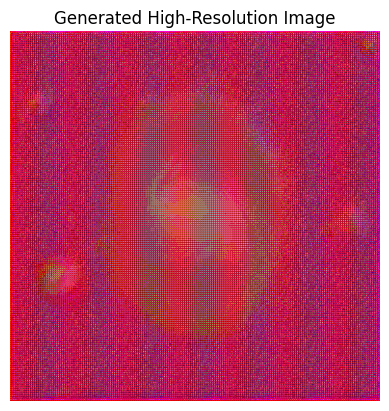

In [ ]:
load_model_and_infer("generator.pth", "/content/drive/MyDrive/AstroSR-main/dataset/HSC_test_HR/135.36111_3.4140265.png")

<ipython-input-10-31e5e3b282f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


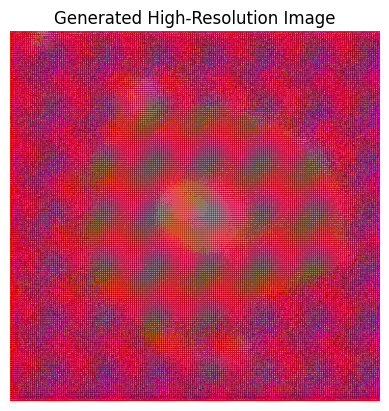

In [ ]:
load_model_and_infer("generator.pth", "/content/drive/MyDrive/AstroSR-main/dataset/HSC_test_HR/141.02951_2.3688948.png")

<ipython-input-10-31e5e3b282f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


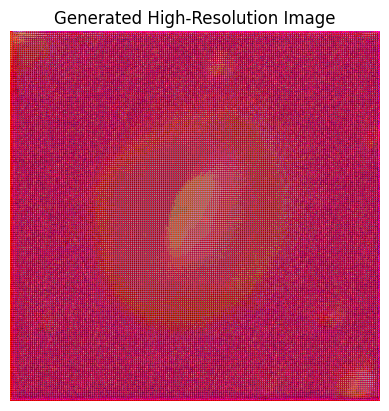

In [ ]:
load_model_and_infer("generator.pth", "/content/drive/MyDrive/AstroSR-main/dataset/HSC_test_HR/132.99406_4.416162.png")